In [13]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import resample

# Load the dataset
data = pd.read_csv('marathi.csv')  # Adjust to your dataset path

# Define Gujarati stopwords
marathi_stopwords = set(["आहे", "आहेस", "आहेत", "होते", "होतेस", "होतेत", "झालं", "झाली", "झाले", "हे", "तो", "ती", "ते", "या", "या", "मी", "आम्ही", "तू", "तुम्ही", "आम्हाला", "तुला", "तुम्हाला", "माझं", "तुझं", "तिचं", "त्याचं", "त्यांचं", "त्यांचा", "तिचा", "तिचं", "त्यात", "त्यावर", "त्याच्या", "यांच्या", "हा", "ह्या", "त्या", "मी", "आम्हाला", "आहे", "होते", "नाही", "कधी", "कुठे", "का", "जेव्हा", "जे", "कोण", "कसा", "कसे", "किती", "इथे", "तिथे", "आता", "पुन्हा", "म्हणून", "किंवा", "पण", "मात्र", "म्हणूनच", "जर", "तर", "आणि", "बरोबर", "नाहीतर", "शक्यतो", "सगळे", "संपूर्ण", "काही", "कोणता", "कोणती", "कोणते", "काय", "कुठला", "कुठेही", "कुणीही", "काहीच", "काहीही", "सर्व", "तसेच", "म्हणूनच", "आता", "पुढे", "मागे", "नेहमी", "थोडा", "खूप", "मोठा", "छोटा", "साधारण", "पूर्ण", "नंतर"
])

# Preprocess text
def preprocess_text(text):
    text = re.sub(r'[^\u0900-\u097F ]', '', text)  # Keep only Marathi (Devanagari) characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    return text

data['cleaned_sentence'] = data['Sentence'].apply(preprocess_text)

# Encode the target labels for Sentiment and Emotion
sentiment_encoder = LabelEncoder()
emotion_encoder = LabelEncoder()
data['encoded_sentiment'] = sentiment_encoder.fit_transform(data['Sentiment'])
data['encoded_emotion'] = emotion_encoder.fit_transform(data['Emotion'])

# Handle class imbalance (oversampling minority classes)
sentiment_counts = data['encoded_sentiment'].value_counts()
min_class = sentiment_counts.idxmin()

# Resample the minority class to match the majority
minority_class = data[data['encoded_sentiment'] == min_class]
majority_class = data[data['encoded_sentiment'] != min_class]
minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)
data_balanced = pd.concat([majority_class, minority_upsampled])

# Split data into training and test sets
X_train, X_test, y_sentiment_train, y_sentiment_test, y_emotion_train, y_emotion_test = train_test_split(
    data_balanced['cleaned_sentence'], data_balanced['encoded_sentiment'], data_balanced['encoded_emotion'], test_size=0.2, random_state=42)

# Tokenize the text data and pad sequences for uniform length
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to make them the same length
max_seq_len = max([len(seq) for seq in X_train_seq])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_len)

# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional

# Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        query, value = inputs
        score = tf.matmul(query, value, transpose_b=True)
        distribution = tf.nn.softmax(score, axis=-1)
        attention_output = tf.matmul(distribution, value)
        return attention_output

# Build the LSTM model with Attention and Bidirectional LSTM
embedding_dim = 128
lstm_units = 64

# Input layer
input_layer = Input(shape=(max_seq_len,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_len)(input_layer)

# Bidirectional LSTM layer
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding_layer)

# Attention layer
attention_output = AttentionLayer()([lstm_layer, lstm_layer])

# Flatten attention output
flatten_attention = attention_output[:, -1, :]  # Use the final step of attention output

# Shared Dense layer
shared_dense_layer = Dense(64, activation='relu')(flatten_attention)

# Sentiment output
sentiment_output = Dense(len(sentiment_encoder.classes_), activation='softmax', name='sentiment_output')(shared_dense_layer)

# Emotion output
emotion_output = Dense(len(emotion_encoder.classes_), activation='softmax', name='emotion_output')(shared_dense_layer)

# Define the model
model = Model(inputs=input_layer, outputs=[sentiment_output, emotion_output])

# Compile the model with class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights_sentiment = compute_class_weight('balanced', classes=np.unique(y_sentiment_train), y=y_sentiment_train)
class_weights_emotion = compute_class_weight('balanced', classes=np.unique(y_emotion_train), y=y_emotion_train)

model.compile(optimizer='adam',
              loss={'sentiment_output': 'sparse_categorical_crossentropy', 'emotion_output': 'sparse_categorical_crossentropy'},
              metrics={'sentiment_output': 'accuracy', 'emotion_output': 'accuracy'},
              loss_weights={'sentiment_output': class_weights_sentiment, 'emotion_output': class_weights_emotion})

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 24)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 24, 128)        │      1,258,496 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 24, 128)        │         98,816 │ embedding_1[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer_1         │ (None, 24, 128)        │              0 │ bidirectional[0][0],   │
│ (AttentionLayer)          │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 128)            │              0 │ attention_layer_1[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ get_item_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment_output (Dense)  │ (None, 3)              │            195 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emotion_output (Dense)    │ (None, 9)              │            585 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,366,348 (5.21 MB)

 Trainable params: 1,366,348 (5.21 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Compile the model without loss_weights
model.compile(optimizer='adam',
              loss={'sentiment_output': 'sparse_categorical_crossentropy',
                    'emotion_output': 'sparse_categorical_crossentropy'},
              metrics={'sentiment_output': 'accuracy', 'emotion_output': 'accuracy'})


In [16]:
import numpy as np
from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights for sentiment and emotion separately
sample_weights_sentiment = compute_sample_weight('balanced', y_sentiment_train)
sample_weights_emotion = compute_sample_weight('balanced', y_emotion_train)

# Combine sample weights (average them)
sample_weights_combined = (sample_weights_sentiment + sample_weights_emotion) / 2


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with the combined sample weights
history = model.fit(
    X_train_pad,
    {'sentiment_output': y_sentiment_train, 'emotion_output': y_emotion_train},
    epochs=10,  # Train for more epochs, but early stopping will prevent overfitting
    batch_size=128,
    validation_data=(X_test_pad, {'sentiment_output': y_sentiment_test, 'emotion_output': y_emotion_test}),
    callbacks=[early_stopping],
    # Provide single combined sample weights (applied to the entire model)
    sample_weight=sample_weights_combined
)


Epoch 1/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - emotion_output_accuracy: 0.9070 - loss: 0.2302 - sentiment_output_accuracy: 0.9927 - val_emotion_output_accuracy: 0.9296 - val_loss: 0.1367 - val_sentiment_output_accuracy: 0.9971
Epoch 2/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - emotion_output_accuracy: 0.9358 - loss: 0.1518 - sentiment_output_accuracy: 0.9977 - val_emotion_output_accuracy: 0.9381 - val_loss: 0.1127 - val_sentiment_output_accuracy: 0.9979
Epoch 3/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - emotion_output_accuracy: 0.9417 - loss: 0.1308 - sentiment_output_accuracy: 0.9985 - val_emotion_output_accuracy: 0.9374 - val_loss: 0.1186 - val_sentiment_output_accuracy: 0.9975
Epoch 4/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - emotion_output_accuracy: 0.9456 - loss: 0.1208 - sentiment_output_accuracy: 0.9989 - val_emotion_output_accuracy: 0.9384 - val_loss: 0.1090 - val_sentiment_output_accuracy: 0.9986
Epoch 5/10
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 18s 11

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict sentiment and emotion on test data
y_sentiment_pred, y_emotion_pred = model.predict(X_test_pad)

# Convert predictions to class labels
y_sentiment_pred_labels = np.argmax(y_sentiment_pred, axis=1)
y_emotion_pred_labels = np.argmax(y_emotion_pred, axis=1)

# Sentiment evaluation metrics
sentiment_accuracy = accuracy_score(y_sentiment_test, y_sentiment_pred_labels)
sentiment_precision = precision_score(y_sentiment_test, y_sentiment_pred_labels, average='weighted')
sentiment_recall = recall_score(y_sentiment_test, y_sentiment_pred_labels, average='weighted')
sentiment_f1 = f1_score(y_sentiment_test, y_sentiment_pred_labels, average='weighted')
sentiment_conf_matrix = confusion_matrix(y_sentiment_test, y_sentiment_pred_labels)

# Emotion evaluation metrics
emotion_accuracy = accuracy_score(y_emotion_test, y_emotion_pred_labels)
emotion_precision = precision_score(y_emotion_test, y_emotion_pred_labels, average='weighted')
emotion_recall = recall_score(y_emotion_test, y_emotion_pred_labels, average='weighted')
emotion_f1 = f1_score(y_emotion_test, y_emotion_pred_labels, average='weighted')
emotion_conf_matrix = confusion_matrix(y_emotion_test, y_emotion_pred_labels)

# Display results
print(f"Sentiment - Accuracy: {sentiment_accuracy}, Precision: {sentiment_precision}, Recall: {sentiment_recall}, F1 Score: {sentiment_f1}")
print(f"Emotion - Accuracy: {emotion_accuracy}, Precision: {emotion_precision}, Recall: {emotion_recall}, F1 Score: {emotion_f1}")
print("Sentiment Confusion Matrix:")
print(sentiment_conf_matrix)
print("Emotion Confusion Matrix:")
print(emotion_conf_matrix)


1667/1667 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Sentiment - Accuracy: 0.9990062437890237, Precision: 0.9990064814104684, Recall: 0.9990062437890237, F1 Score: 0.9990063153619103
Emotion - Accuracy: 0.9422683891774324, Precision: 0.9439252424383708, Recall: 0.9422683891774324, F1 Score: 0.9414418015082243
Sentiment Confusion Matrix:
[[13271     0    11]
 [    1 13251    18]
 [    0    23 26758]]
Emotion Confusion Matrix:
[[4326    0    8    0    2    1    0    8    1]
 [   0 4445    0    0    0    1    0    0    1]
 [   1    0 4461    0   10    1    0    7    0]
 [   0    1    0 2420    0    4    4    0 2016]
 [   1    0   16    0 9044    7    0    0    0]
 [   0    0    1    0    1 8863    0    0    0]
 [   5    0    1    0    5    0 8837    0    0]
 [   0    0   12    0    1    0    0 4431    0]
 [   0    2    2  954    0    4    1    0 3427]]


1667/1667 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


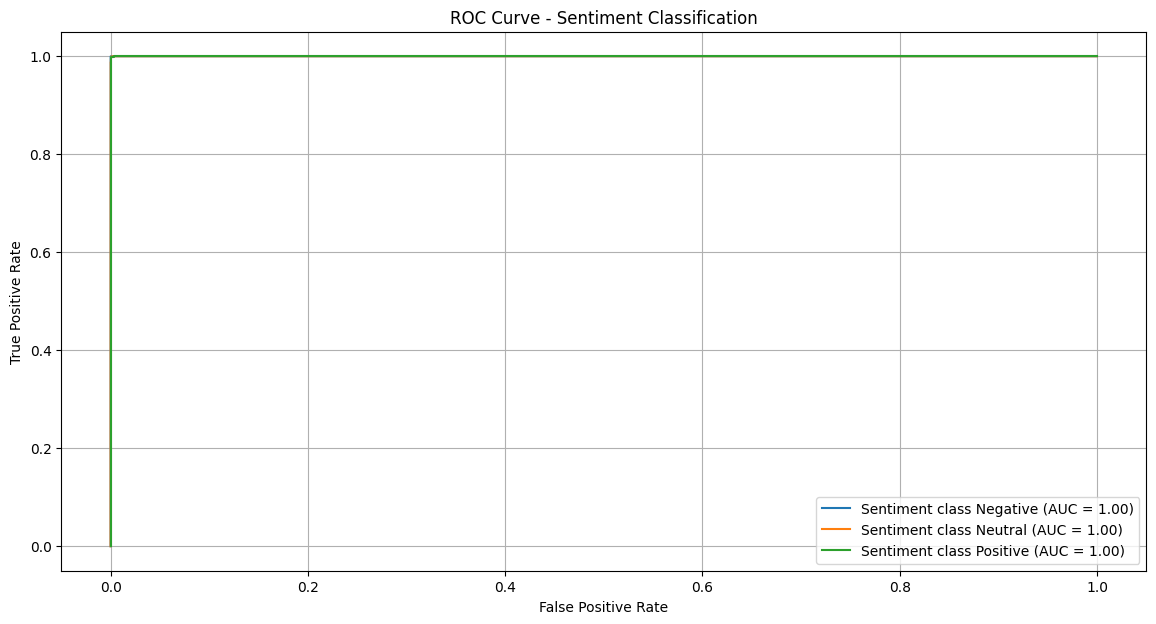

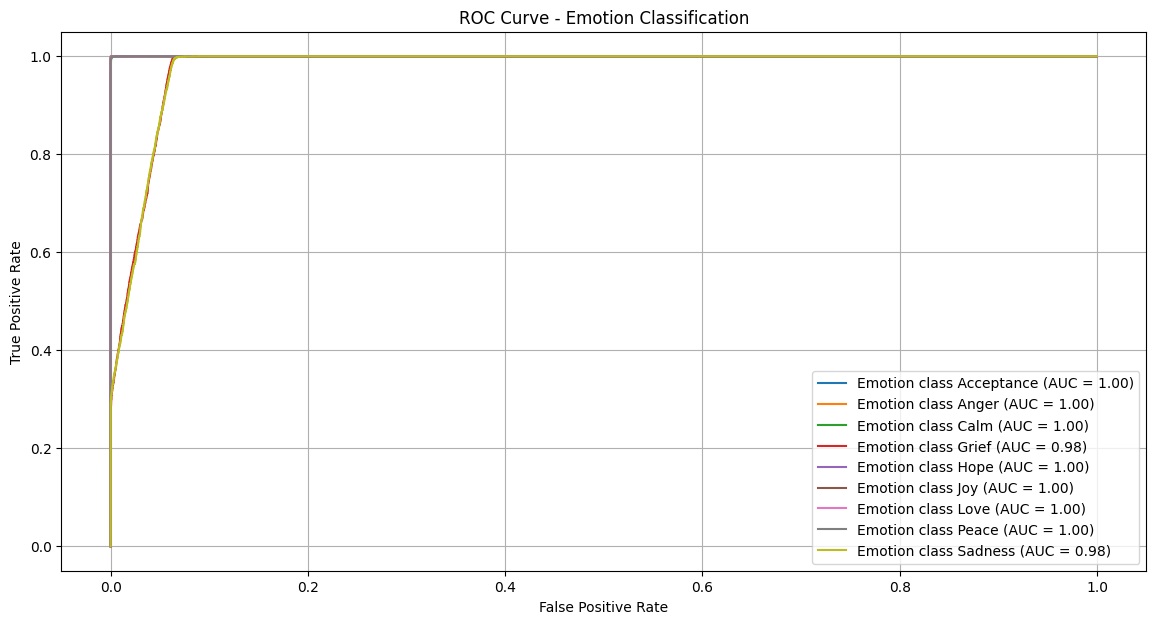

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the sentiment and emotion labels for AUC calculation
y_sentiment_test_binarized = label_binarize(y_sentiment_test, classes=range(len(sentiment_encoder.classes_)))
y_emotion_test_binarized = label_binarize(y_emotion_test, classes=range(len(emotion_encoder.classes_)))

# Get the predicted probabilities for each class
y_sentiment_pred_prob, y_emotion_pred_prob = model.predict(X_test_pad)

# Plot ROC curve for each sentiment class
plt.figure(figsize=(14, 7))
for i in range(len(sentiment_encoder.classes_)):
    fpr, tpr, _ = roc_curve(y_sentiment_test_binarized[:, i], y_sentiment_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Sentiment class {sentiment_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

# Add labels and legends
plt.title('ROC Curve - Sentiment Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot ROC curve for each emotion class
plt.figure(figsize=(14, 7))
for i in range(len(emotion_encoder.classes_)):
    fpr, tpr, _ = roc_curve(y_emotion_test_binarized[:, i], y_emotion_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Emotion class {emotion_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

# Add labels and legends
plt.title('ROC Curve - Emotion Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


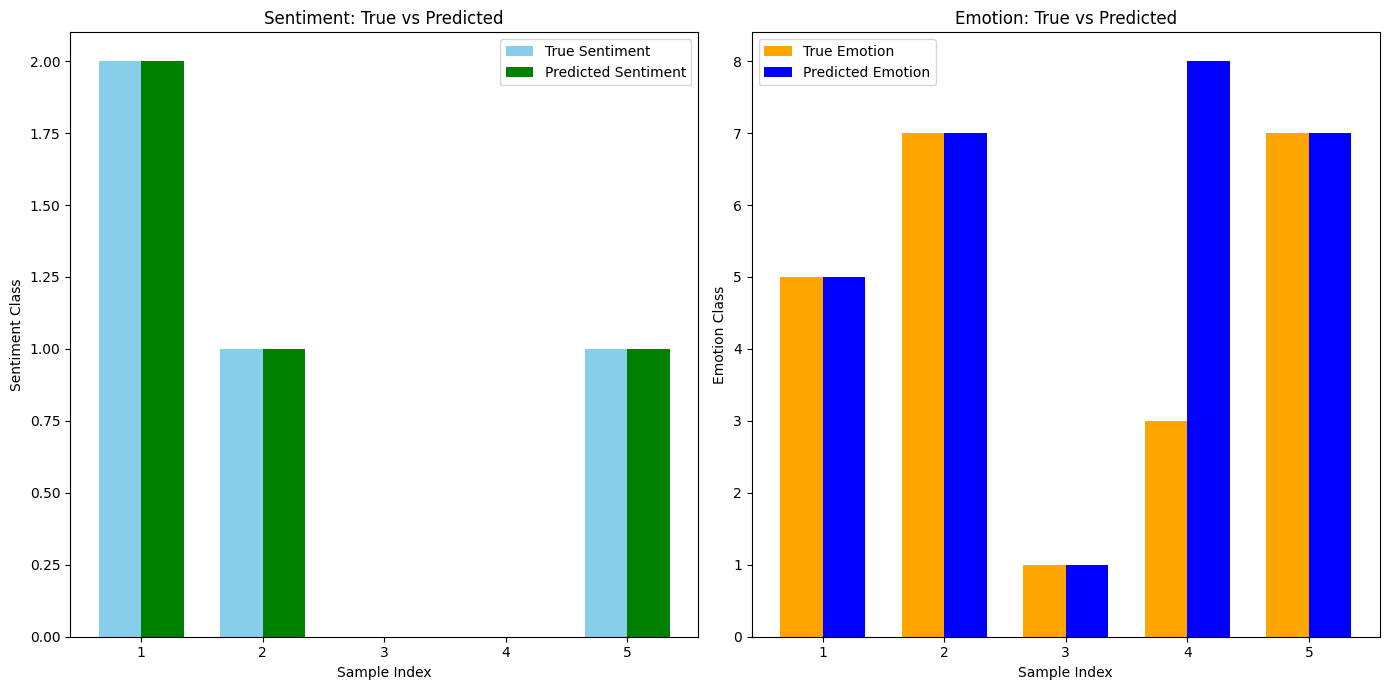

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Convert X_test, y_sentiment_test, and y_emotion_test to NumPy arrays if they are pandas Series
X_test_np = np.array(X_test)
y_sentiment_test_np = np.array(y_sentiment_test)
y_emotion_test_np = np.array(y_emotion_test)

# Randomly select 5 sentences from the test set for testing
random_sample_indices = np.random.choice(len(X_test_pad), size=5, replace=False)

# Use the random indices to select sentences and their true labels
sample_sentences = X_test_np[random_sample_indices]  # These are the cleaned sentences
sample_true_sentiments = y_sentiment_test_np[random_sample_indices]
sample_true_emotions = y_emotion_test_np[random_sample_indices]

# Predict sentiment and emotion for the random samples
sample_sentiment_pred, sample_emotion_pred = model.predict(X_test_pad[random_sample_indices])
sample_sentiment_pred_labels = np.argmax(sample_sentiment_pred, axis=1)
sample_emotion_pred_labels = np.argmax(sample_emotion_pred, axis=1)

# Set up the figure
plt.figure(figsize=(14, 7))

# Sentiment Comparison Bar Plot
plt.subplot(1, 2, 1)
x = np.arange(len(sample_sentences))  # Label locations
bar_width = 0.35  # Width of the bars

# Plot bars for true sentiment
plt.bar(x - bar_width / 2, sample_true_sentiments, width=bar_width, color='skyblue', label='True Sentiment')

# Plot bars for predicted sentiment
plt.bar(x + bar_width / 2, sample_sentiment_pred_labels, width=bar_width, color='green', label='Predicted Sentiment')

# Label the plot
plt.title('Sentiment: True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Sentiment Class')
plt.xticks(x, range(1, len(sample_sentences) + 1))
plt.legend()

# Emotion Comparison Bar Plot
plt.subplot(1, 2, 2)

# Plot bars for true emotion
plt.bar(x - bar_width / 2, sample_true_emotions, width=bar_width, color='orange', label='True Emotion')

# Plot bars for predicted emotion
plt.bar(x + bar_width / 2, sample_emotion_pred_labels, width=bar_width, color='blue', label='Predicted Emotion')

# Label the plot
plt.title('Emotion: True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Emotion Class')
plt.xticks(x, range(1, len(sample_sentences) + 1))
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


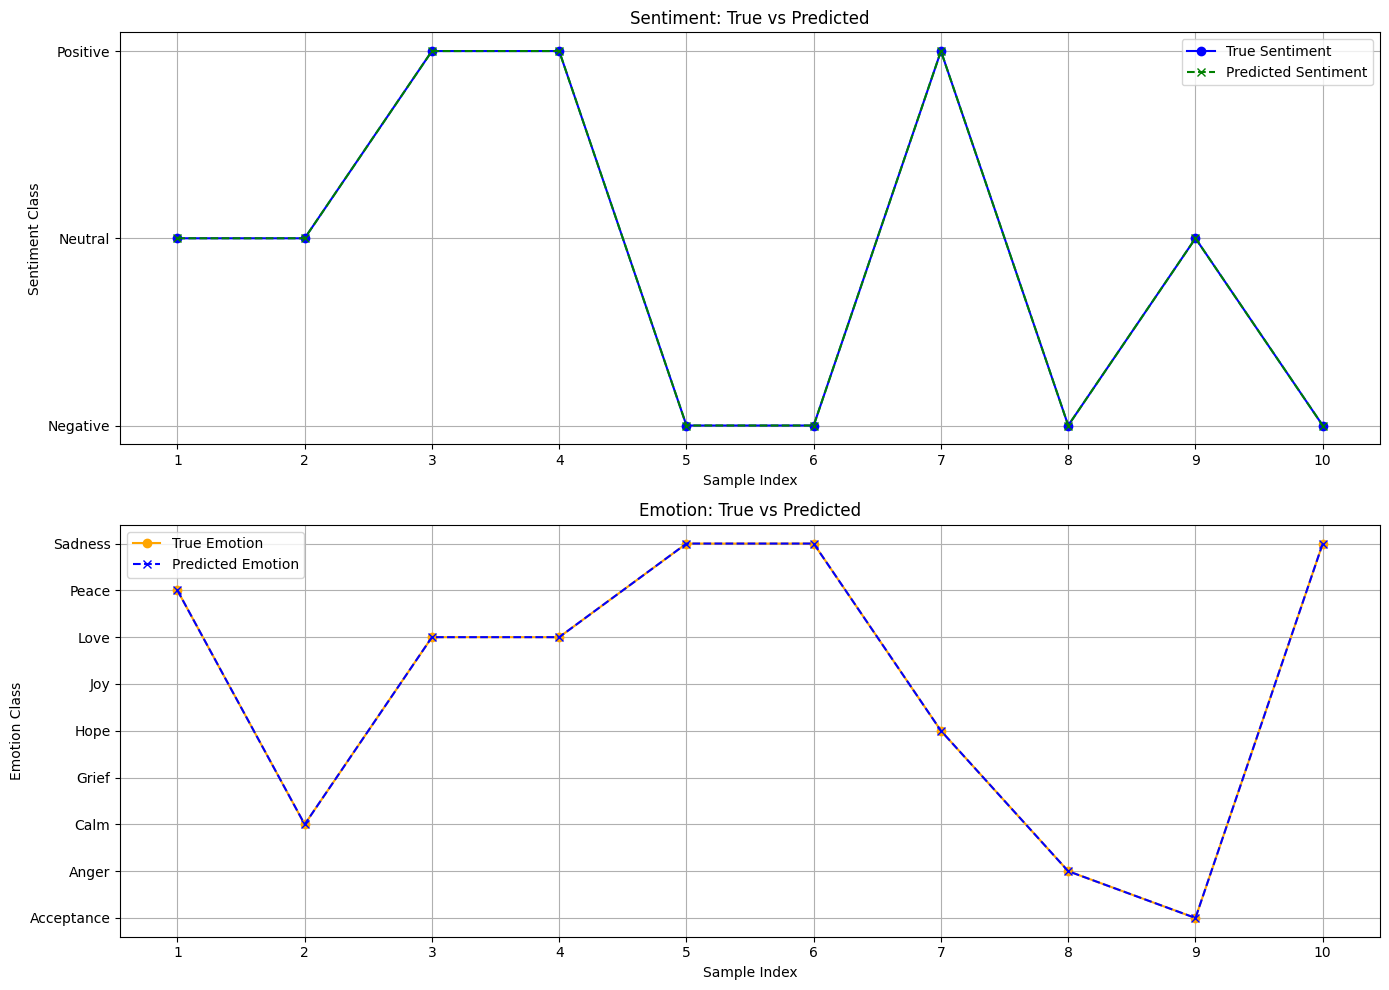

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Convert X_test, y_sentiment_test, and y_emotion_test to NumPy arrays if they are pandas Series
X_test_np = np.array(X_test)
y_sentiment_test_np = np.array(y_sentiment_test)
y_emotion_test_np = np.array(y_emotion_test)

# Randomly select 5 sentences from the test set for testing
random_sample_indices = np.random.choice(len(X_test_pad), size=10, replace=False)

# Use the random indices to select sentences and their true labels
sample_sentences = X_test_np[random_sample_indices]  # These are the cleaned sentences
sample_true_sentiments = y_sentiment_test_np[random_sample_indices]
sample_true_emotions = y_emotion_test_np[random_sample_indices]

# Predict sentiment and emotion for the random samples
sample_sentiment_pred, sample_emotion_pred = model.predict(X_test_pad[random_sample_indices])
sample_sentiment_pred_labels = np.argmax(sample_sentiment_pred, axis=1)
sample_emotion_pred_labels = np.argmax(sample_emotion_pred, axis=1)

# Get all possible sentiment and emotion labels
sentiment_classes = sentiment_encoder.classes_  # All possible sentiment labels
emotion_classes = emotion_encoder.classes_  # All possible emotion labels

# Set up the line graph figure
plt.figure(figsize=(14, 10))

# Sentiment Plot: True vs Predicted
plt.subplot(2, 1, 1)
plt.plot(range(1, len(sample_sentences) + 1), sample_true_sentiments, marker='o', linestyle='-', color='blue', label='True Sentiment')
plt.plot(range(1, len(sample_sentences) + 1), sample_sentiment_pred_labels, marker='x', linestyle='--', color='green', label='Predicted Sentiment')
plt.title('Sentiment: True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Sentiment Class')
plt.xticks(range(1, len(sample_sentences) + 1))  # x-axis represents the 5 randomly selected sentences
plt.yticks(ticks=range(len(sentiment_classes)), labels=sentiment_classes)  # Show all sentiment classes on y-axis
plt.legend()
plt.grid(True)

# Emotion Plot: True vs Predicted
plt.subplot(2, 1, 2)
plt.plot(range(1, len(sample_sentences) + 1), sample_true_emotions, marker='o', linestyle='-', color='orange', label='True Emotion')
plt.plot(range(1, len(sample_sentences) + 1), sample_emotion_pred_labels, marker='x', linestyle='--', color='blue', label='Predicted Emotion')
plt.title('Emotion: True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Emotion Class')
plt.xticks(range(1, len(sample_sentences) + 1))  # x-axis represents the 5 randomly selected sentences
plt.yticks(ticks=range(len(emotion_classes)), labels=emotion_classes)  # Show all emotion classes on y-axis
plt.legend()
plt.grid(True)

# Adjust the layout and display the graph
plt.tight_layout()
plt.show()


In [38]:
# Define custom Gujarati sentences for testing
custom_sentences = ["तुझ्या कटू शब्दांनी मनात धगधगणारा अंगार अजून तीव्र होत चालला आहे",
"तुझं अशा रीतीने दूर जाणं जणू प्रत्येक दिवस थोडा थोडा कमी उजेडाचा होत जातोय",
"सत्य समोर आलं तेव्हा सगळ्या स्वप्नांचा चुराडा झाल्याचं जाणवलं, पण तरीही चालावं लागतं",
"शांततेत बसून वाऱ्याच्या हळुवार स्पर्शात विश्वाचं गूढ हळूहळू उलगडत जातं",
"तुझ्या सहवासात प्रत्येक क्षणाचं अनमोल महत्त्व उमजतं, आणि जग सुंदर भासतं"



]

# English translations of the custom sentences
english_translations = ["Your bitter words have only intensified the smoldering fire within me",
"Your departure in this manner makes it feel like each day grows dimmer and dimmer",
"When the truth came forward, it felt like all dreams shattered, yet the journey must continue",
"Sitting quietly and feeling the gentle touch of the wind, the mysteries of the universe slowly unfold",
"Every moment with you feels precious, and the world seems beautiful in your presence"


]

# Preprocess and tokenize the custom sentences
custom_sequences = tokenizer.texts_to_sequences(custom_sentences)
custom_padded_sequences = pad_sequences(custom_sequences, maxlen=max_seq_len)

# Predict sentiment and emotion using the trained model
custom_sentiment_pred, custom_emotion_pred = model.predict(custom_padded_sequences)

# Convert predictions to class labels
custom_sentiment_pred_labels = np.argmax(custom_sentiment_pred, axis=1)
custom_emotion_pred_labels = np.argmax(custom_emotion_pred, axis=1)

# Get the label names from encoders
predicted_sentiment_labels = sentiment_encoder.inverse_transform(custom_sentiment_pred_labels)
predicted_emotion_labels = emotion_encoder.inverse_transform(custom_emotion_pred_labels)

# Display the results for each sentence
for i, sentence in enumerate(custom_sentences):
    print(f"Sentence (Gujarati): {sentence}")
    print(f"English Translation: {english_translations[i]}")
    print(f"Predicted Sentiment: {predicted_sentiment_labels[i]}")
    print(f"Predicted Emotion: {predicted_emotion_labels[i]}")
    print("----------------------------------------------------")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Sentence (Gujarati): तुझ्या कटू शब्दांनी मनात धगधगणारा अंगार अजून तीव्र होत चालला आहे
English Translation: Your bitter words have only intensified the smoldering fire within me
Predicted Sentiment: Negative
Predicted Emotion: Anger
----------------------------------------------------
Sentence (Gujarati): तुझं अशा रीतीने दूर जाणं जणू प्रत्येक दिवस थोडा थोडा कमी उजेडाचा होत जातोय
English Translation: Your departure in this manner makes it feel like each day grows dimmer and dimmer
Predicted Sentiment: Negative
Predicted Emotion: Sadness
----------------------------------------------------
Sentence (Gujarati): सत्य समोर आलं तेव्हा सगळ्या स्वप्नांचा चुराडा झाल्याचं जाणवलं, पण तरीही चालावं लागतं
English Translation: When the truth came forward, it felt like all dreams shattered, yet the journey must continue
Predicted Sentiment: Positive
Predicted Emotion: Hope
----------------------------------------------------
Sentence (Gujarati): शांततेत बसून वाऱ्या